In [1]:
import numpy as np
import scipy as sc
import pandas as pd
import pymc3 as pm
import matplotlib.pyplot as plt
import seaborn as sns
import csv
import itertools
%matplotlib inline

WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [2]:
from os import listdir
from os.path import isfile, join
path = '../RetweetDataAOAS/retweet_data/'
root_tweet_names = [f for f in listdir(path) if isfile(join(path, f))]

In [4]:
# Produces a dictionary of dataframes for each tweetfile, with initial 
# preprocessing
fields = ['RetweetCount', 'UserId', 'ScreenName', 'FollowerCount', 
          'DistanceFromRoot','Time', 'ParentScreenName', 'Text']
tweet_dfs = {}
for i in range(len(root_tweet_names)):
    tweet_df = pd.read_csv(path+root_tweet_names[i], sep="\t", header=None, 
                         quoting=csv.QUOTE_NONE, names=fields, encoding = "ISO-8859-1")
    
    tweet_df['Time'] = pd.to_datetime(tweet_df['Time'])

    screen_name_index = {}
    for index, row in tweet_df.iterrows():
        screen_name_index[row['ScreenName']] = index
    tweet_df['ParentDfIndex'] = tweet_df['ParentScreenName'].map(screen_name_index)
    tweet_df[['FollowerCount','UserId']] = tweet_df[['FollowerCount','UserId']].apply(pd.to_numeric, errors='coerce')
    tweet_df[['FollowerCount','UserId']] = tweet_df[['FollowerCount','UserId']].fillna(0)
    
    tweet_dfs[i] = tweet_df

In [5]:
# Returns a dictionary of reaction times S_j^x keyed by user id
def generate_reaction_times(tweet_df):
    reaction_times = {}
    for index, row in tweet_df.iterrows():
        if index > 0:
            reaction_time = row['Time'] - tweet_df.at[row['ParentDfIndex'],
                                                      'Time']
            reaction_times[row['UserId']] = reaction_time
    return reaction_times

In [6]:
# Returns a dictionary of M_j^x keyed by user id
def generate_number_of_follower_who_retweet(tweet_df):
    number_of_follower_who_retweet = {}
    for index, row in tweet_df.iterrows():
        if row['UserId'] not in number_of_follower_who_retweet:
            number_of_follower_who_retweet[row['UserId']] = 0
        parent_user_id = tweet_df.at[row['ParentDfIndex'], 'UserId']
        number_of_follower_who_retweet[parent_user_id] += 1
    return number_of_follower_who_retweet

In [7]:
tweet_df_1 = tweet_dfs[1]
s_j_x = sorted(generate_reaction_times(tweet_df_1).values())
log_s_j_x = [np.log(i.seconds) for i in s_j_x]
tweet_df_1_users = list(tweet_df_1['UserId'])
m_j_x_dic = generate_number_of_follower_who_retweet(tweet_df_1)
m_j_x_lis = []
for key in m_j_x_dic.keys():
    m_j_x_lis.append(m_j_x_dic[key])

In [8]:
print(root_tweet_names)

['Source_followers_tweet_0074_iamwill.txt', 'Source_followers_tweet_0127_hilaryr.txt', 'Source_followers_tweet_0271_hilaryr.txt', 'Source_followers_tweet_0022_Lawrence.txt', 'Source_followers_tweet_0024_pbsgwen.txt', 'Source_followers_tweet_0026_realMickFoley.txt', 'Source_followers_tweet_0028_AnnCoulter.txt', 'Source_followers_tweet_0031_ASAPYams.txt', 'Source_followers_tweet_0031_CNET.txt', 'Source_followers_tweet_0037_EvaLongoria.txt', 'Source_followers_tweet_0044_JonnyBones.txt', 'Source_followers_tweet_0048_MissInfoTV.txt', 'Source_followers_tweet_0068_CharlesMBlow.txt', 'Source_followers_tweet_0069_bobatl.txt', 'Source_followers_tweet_0070_E40.txt', 'Source_followers_tweet_0074_Tip.txt', 'Source_followers_tweet_0085_MrChuckD.txt', 'Source_followers_tweet_0091_CharlesMBlow.txt', 'Source_followers_tweet_0092_AnnCoulter.txt', 'Source_followers_tweet_0092_jasonsegel.txt', 'Source_followers_tweet_0101_GarryShandling.txt', 'Source_followers_tweet_0101_myfabolouslife.txt', 'Source_follo

In [8]:
with pm.Model() as strawman_model:
    lamb = pm.Gamma('lambda', alpha=1, beta=1./500)
    m_preds = pm.Poisson('follower_count', mu=lamb, observed=m_j_x_lis, shape=len(m_j_x_lis))

In [9]:
# Run and fit our model
with strawman_model:
    trace = pm.sample(1000, tune=2000, cores=4)


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [lambda_log__]
100%|██████████| 3000/3000 [00:01<00:00, 2079.59it/s]


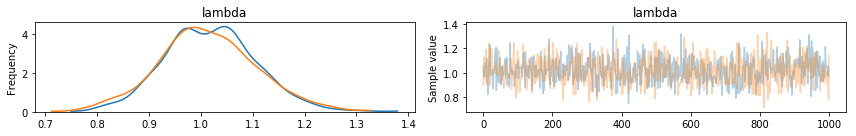

In [10]:
with strawman_model:
    pm.traceplot(trace);


In [9]:
# linear regression model setup

followers_array = []
retweets_array = []

for i in range(len(root_tweet_names)):
    # todo: need to do train / test split
    name = root_tweet_names[i]
    count = int(tweet_dfs[i].iloc[0]["FollowerCount"])
    followers_array.append(count)
    retweets_array.append(len(tweet_dfs[i]) - 1) 

followers_array_log = np.log(np.array(followers_array))
retweets_array_log = np.log(np.array(retweets_array))

data = dict(x = followers_array_log, y = retweets_array_log)

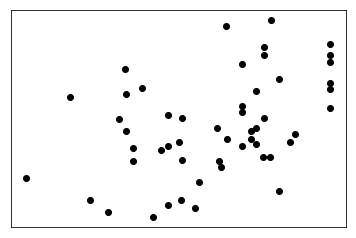

In [10]:
# Plot outputs
plt.scatter(followers_array_log, retweets_array_log,  color='black')

plt.xticks(())
plt.yticks(())

plt.show()

In [15]:
followers_array_log.shape


(52,)

In [24]:
with pm.Model() as linear_regression_model:
    # Define priors
    sigma = pm.HalfCauchy('sigma', beta=10, testval=1.)
    beta_0 = pm.Normal('beta_0', 0, sd=20)
    beta_1 = pm.Normal('beta_1', 0, sd=20)
    
#     error_array = []
#     for i in range(len(root_tweet_names)):
#         # todo: need to do train / test split
#         e_x = pm.Normal("e_{}".format(i), 0, sd=100) #what to set for sd
#         error_array.append(e_x)
#     error_array = np.array(error_array)
        
    e_x = pm.Normal("e", 0, sd = 1, shape = (52,1))

    # Define likelihood
    
#     temp = pm.Deterministic("temparray", beta_0 + beta_1 * followers_array_log + error_array)
    
    likelihood = pm.Normal('y', mu=beta_0 + beta_1 * followers_array_log + e_x,
                        sd=sigma, observed=retweets_array_log)

In [25]:
# Run and fit our model
with linear_regression_model:
    trace = pm.sample(1000, tune=3000, cores=4)


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [e, beta_1, beta_0, sigma_log__]
100%|██████████| 4000/4000 [00:30<00:00, 130.59it/s]
The estimated number of effective samples is smaller than 200 for some parameters.


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f3e860cd150>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x7f3e8554ac50>]], dtype=object)

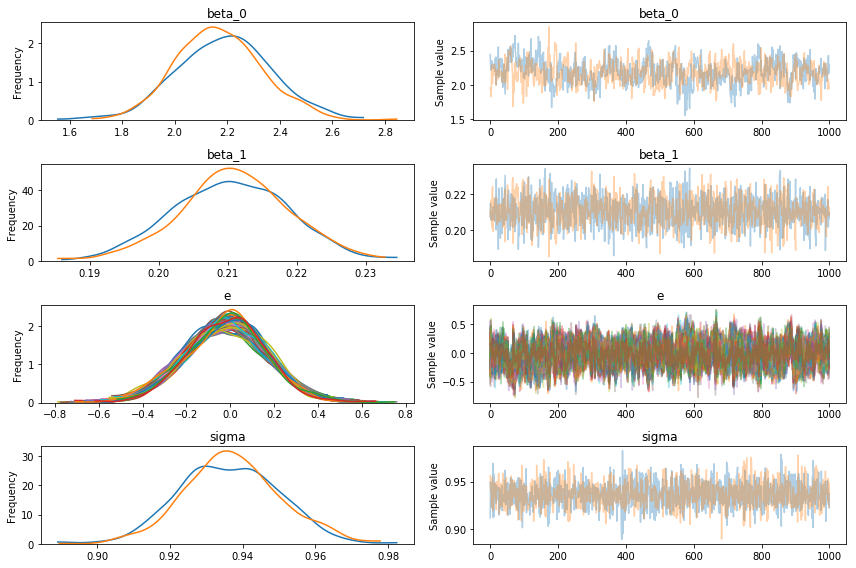

In [26]:
pm.traceplot(trace)

In [16]:
# alternative model 
with pm.Model() as glm_model:
    pm.glm.GLM.from_formula('y ~ x', data)
    trace = pm.sample(1000, tune=3000, cores=2)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sd_log__, x, Intercept]
100%|██████████| 4000/4000 [00:11<00:00, 345.50it/s]


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fa7a008e9d0>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x7fa79f194b50>]], dtype=object)

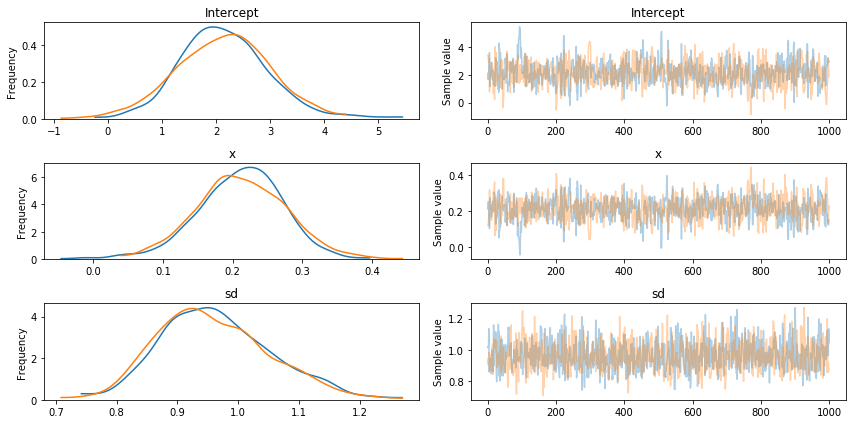

In [17]:
pm.traceplot(trace)

In [94]:
from sklearn import datasets, linear_model
from sklearn.metrics import mean_squared_error, r2_score


In [96]:
followers_array_log = np.array(followers_array, ndmin=2)
followers_array_log = np.transpose(np.log(followers_array_log))

retweets_array_log = np.array(retweets_array, ndmin=2)
retweets_array_log = np.transpose(np.log(retweets_array_log))

In [97]:
# Create linear regression object
regr = linear_model.LinearRegression()

# Train the model using the training sets
regr.fit(followers_array_log, retweets_array_log)

# The coefficients
print('Coefficients: \n', regr.coef_)
# The mean squared error
# print("Mean squared error: %.2f"
#       % mean_squared_error(diabetes_y_test, diabetes_y_pred))
# # Explained variance score: 1 is perfect prediction
# print('Variance score: %.2f' % r2_score(diabetes_y_test, diabetes_y_pred))

('Coefficients: \n', array([[ 0.2106125]]))
